# Regional distribution of precipitation

In [2]:
import sys
import os
aps_path = os.path.dirname(os.path.abspath("."))
sys.path.append(aps_path)
print(aps_path)

D:\Dev\APS\aps


In [103]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from aps_io.get_arome import nc_load

In [4]:
%matplotlib inline

In [148]:
import warnings
warnings.filterwarnings('ignore')

Read precipitation data from netcdf file and clip to a subregion.

In [64]:
nc = Dataset("../data/met_obs_grid/rr_2016_12_12.nc", "r")

time_var = nc.variables['time']
#altitude_var = nc.variables['altitude']
precip_var = nc.variables['precipitation_amount']

In [176]:
x1, x2 = 550, 750
y1, y2 = 250, 500

precip = precip_var[0, y1:y2, x1:x2]

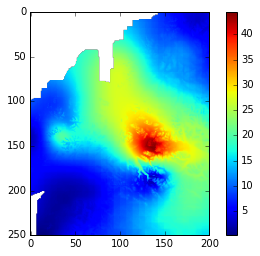

In [177]:
plt.imshow(precip, aspect='equal')
plt.colorbar()
plt.show()

In [178]:
pf = precip.flatten()
print(pf)
pfc = np.clip(pf, 0, 1000)

box_bot = np.nanpercentile(pfc, 25.0)
box_top = np.nanpercentile(pfc, 75.0)
box_center = np.nanpercentile(pfc, 50.0)
flier_low = np.min(pfc) #np.nanpercentile(precip, 5.0)
flier_high = np.max(pfc) #np.nanpercentile(precip, 95.0)
pf_mean = np.nanmean(pfc)
#box_data = np.concatenate((spread, center, flier_high, flier_low), 0)


print(flier_low, box_bot, box_center, box_top, flier_high, pf_mean)

[-- -- -- ..., 15.699999809265137 15.600000381469727 15.600000381469727]
0.3 4.59999990463 12.0 20.2999992371 44.5 15.2478


In [179]:
precip_high = np.greater(precip, box_top)
print(precip_high.shape, precip.shape)

(250, 200) (250, 200)


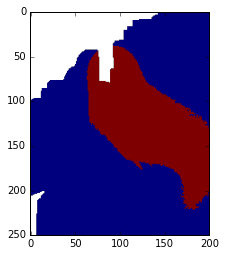

In [180]:
plt.imshow(precip_high, aspect='equal')
plt.show()

In [181]:
window_x = 20; window_y = 20;

In [182]:
step_x = 5; step_y = 5;

In [191]:
i=200; j=0;

In [192]:
Pwin = precip[i:i+window_x, j:j+window_y]
pf = Pwin.flatten()
pfc = np.clip(pf, 0, 1000)

box_bot = np.nanpercentile(pfc, 25.0)
box_top = np.nanpercentile(pfc, 75.0)
box_center = np.nanpercentile(pfc, 50.0)
flier_low = np.min(pfc) #np.nanpercentile(precip, 5.0)
flier_high = np.max(pfc) #np.nanpercentile(precip, 95.0)
pf_mean = np.nanmean(pfc)

print(flier_low, box_bot, box_top, pf_mean)
print(box_center, flier_high)

1.9 0.0 3.0 3.1325
2.40000009537 5.2


In [195]:
highest_med = 0
highest_max = 0

for i in range(0, precip.shape[0]-window_y, step_y):
    for j in range(0, precip.shape[1]-window_x, step_x):
        
        Pwin = precip[i:i+window_y, j:j+window_x]
        
        pf = Pwin.flatten() # make 1-D
        pfc = np.clip(pf, 0, 1000) # remove unrealistic values; should probaby be set to NaN
        
        box_bot = np.nanpercentile(pfc, 25.0)
        box_top = np.nanpercentile(pfc, 75.0)
        box_center = np.nanpercentile(pfc, 50.0)
        flier_low = np.min(pfc) #np.nanpercentile(precip, 5.0) 
        flier_high = np.max(pfc)#np.nanpercentile(precip, 95.0)
        pf_mean = np.nanmean(pfc)
        
        if box_center > highest_med:
            highest_med = box_center
            med_i = i
            med_j = j
        if flier_high > highest_max:
            highest_max = flier_high
            max_i = i
            max_j = j
        #print(flier_low, box_bot, box_center, box_top, flier_high, pf_mean)
        
print(highest_med, med_i, med_j)
print(highest_max, max_i, max_j)

41.2000007629 140 125
44.5 135 120


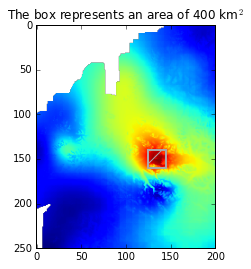

In [207]:
plt.imshow(precip, aspect='equal')
plt.gca().add_patch(Rectangle((med_j, med_i), window_x, window_y, hatch='/', fill=False, edgecolor='darkgrey', linewidth=2))
#plt.gca().add_patch(Rectangle((max_j, max_i), window_x, window_y, hatch='\\', fill=False, edgecolor='lightgrey', linewidth=2))
# the max will be unchanged in a neighboring window with a potentially higher median and not update its position - it can be removed. 
plt.title("The box represents an area of {0} km$^2$".format(window_x*window_y))

## Clustering

### Spectral clustering

In [86]:
print(__doc__)

# Authors:  Emmanuelle Gouillart <emmanuelle.gouillart@normalesup.org>
#           Gael Varoquaux <gael.varoquaux@normalesup.org>
# License: BSD 3 clause

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

Automatically created module for IPython interactive environment


Generate sample data

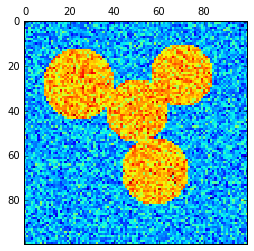

In [77]:
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

plt.matshow(img)

Compute clustering with Spectral clustering

In [89]:
graph = np.double(precip)

In [91]:
# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.matshow(label_im)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:629: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


ValueError: NumPy boolean array indexing assignment cannot assign 200 input values to the 2678 output values where the mask is true

### Affinity propagation

In [37]:
print(__doc__)

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

Automatically created module for IPython interactive environment


Generate sample data

In [53]:
from sklearn.datasets.samples_generator import make_blobs

In [54]:
centers = [[1, 1], [-1, -1], [1, -1]]
precip, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

Compute Affinity propagation

In [56]:
af = AffinityPropagation(preference=-50.).fit(precip)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(precip, labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Silhouette Coefficient: 0.753


Plot results

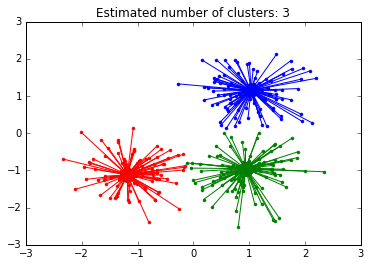

In [57]:
#import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = precip[cluster_centers_indices[k]]
    plt.plot(precip[class_members, 0], precip[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=14)
    for x in precip[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()